# **요약(Summarization)**

매우 많은 양의 문서(context)가 있을 경우, 요약하는 방법
1. 프롬프트에 전부 때려박기 -> LLM아 알아서 요약해줘 => 문서 양이 context window를 넘어가면 사용 불가
2. Map-Reduce: 각 문서를 요약하고(LLM이) 합쳐서 최종 요약본을 만들기(LLM이)

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
from langchain_community.document_loaders import ArxivLoader

loader = ArxivLoader(
    query='reasoning',
)

docs = loader.load()[:2]

In [4]:
from langchain_openai import ChatOpenAI
from langchain.chat_models import init_chat_model


llm = ChatOpenAI(model='gpt-4.1', temperature=0)
# llm = init_chat_model(model='gpt-4o',model_provider='openai', temperature=0)  # 같은 결과

## Stuff Docs(때려박기)

지금 모델에서 논문 2편까지는 어떻게 모델에 때려박는게 가능하지만, 3편부터는 제한에 걸려서 처리가 불가능함

In [5]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([
    ('system', '아래 내용을 정확하게 요약해 줘. \n\n{context}')
])

chain = create_stuff_documents_chain(llm, prompt)

res = chain.invoke({'context': docs})

In [6]:
print(res)

아래 두 논문의 핵심 내용을 각각 정확하게 요약합니다.

---

### 1. **Process or Result? Manipulated Ending Tokens Can Mislead Reasoning LLMs to Ignore the Correct Reasoning Steps**

**핵심 요약:**

- **연구 목적:**  
  최근 수리 추론(Chain-of-Thought, CoT) 능력이 향상된 대형 언어모델(LLM)들이 입력된 추론 과정(Reasoning Tokens)에 미세한 오류가 포함될 때 얼마나 취약한지 분석함.

- **주요 발견:**  
  - **Compromising Thought (CPT) 현상:**  
    추론 과정의 마지막 계산 결과(ending tokens)만 살짝 조작해도, LLM들은 올바른 추론 과정을 무시하고 조작된(잘못된) 결과를 최종 답으로 채택하는 경향이 강함.
  - **자기 교정(Self-correction) 한계:**  
    LLM이 스스로 계산을 정확히 할 수 있음에도, 입력된 조작된 reasoning tokens에 쉽게 영향을 받아 자기 교정 능력이 크게 저하됨.
  - **구조 vs. 내용:**  
    기존 연구와 달리, reasoning chain의 구조적 변화보다 마지막 결과값(ending token)의 국소적 조작이 모델의 추론 결과에 더 큰 영향을 미침.
  - **보안 취약점:**  
    DeepSeek-R1 모델은 조작된 reasoning tokens가 입력되면 아예 추론을 중단(답을 내지 않음)하는 현상도 발견됨.

- **실험 방법:**  
  - 여러 LLM(DeepSeek-R1, OpenAI-o1, o3-mini 등)에 대해, ending token을 한 자리만 바꾸는 등 미세하게 조작한 reasoning tokens를 입력하고, 모델이 이를 얼마나 잘 감지/교정하는지 평가.
  - CPT 저항성을 높이기 위한 3가지 프롬프트(불확실성 유도, 오류 명시, 출력 prefix 강

## Map - Reduce

list(map(int, '12345'))처럼, 문서를 나눠서 각각 요약한다는 뜻

map(reduce, [doc1, doc2, doc3])

1. 문서를 나눔
2. 나눈 문서를 각각 요약
3. 요약본을 합침
4. 다시 요약

여기서부터는 랭그래프가 필요함

In [7]:
from langchain_core.prompts import ChatPromptTemplate

system_prompt = ChatPromptTemplate.from_messages([
    ('system', '아래 내용을 정확하게 요약해 줘. \n\n{context}')
])

In [8]:
reduce_template = '''
이건 요약된 문서들이야.
---
{docs}
---
이 문서들을 취합해서 최종 통합본을 만들어 줘
'''

reduce_prompt = ChatPromptTemplate([
    ('human', reduce_template)
])

### 문서를 더 작은 문서로 쪼개기

In [45]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader(
    web_paths=('https://lilianweng.github.io/posts/2023-06-23-agent/',)
)

docs = loader.load()

In [46]:
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(  # 글자수가 아니라 토큰수에 대해 자름
    chunk_size=1000,
    chunk_overlap=0
)

split_docs = text_splitter.split_documents(docs)

Created a chunk of size 1003, which is longer than the specified 1000


### 그래프 생성

- 영어 문서를 -> 영어인 채로 요약 후 -> 최종 요약 후 번역하는게 토큰을 아낄 수 있음

    한국어가 영어보다 토큰을 많이 쓴다

In [47]:
import operator
from typing_extensions import Annotated, List, Literal, TypedDict
from langchain.chains.combine_documents.reduce import acollapse_docs, split_list_of_docs
from langchain_core.documents import Document
from langgraph.types import Send
from langgraph.graph import START, END, StateGraph

TOKEN_MAX = 2000

# 전체적으로 사용할 State -> reducing 담당
class OverallState(TypedDict): 
    contents: List[str]                         # 문서 조각들의 내용을 리스트에 담은 것
    summaries: Annotated[list, operator.add]    # contents의 요약(노드가 여러 개의 요약을 반환하면, 자동으로 하나씩 리스트에 더해줌)
    collapsed_summaries: List[Document]         # summaries를 다시 List[Document]로 포장
    final_summary: str                          # 최종 요약본
    
# 개별 문서를 처리할 State -> mapping 담당
class SummaryState(TypedDict):
    content: str  # 문서 조각의 내용

In [48]:
# 프롬프트
map_prompt = ChatPromptTemplate.from_messages([
    ("system", "Write a concise summary of the following:\\n\\n{context}")
])

reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary
of the main themes. 
Answer in Korean.
"""

reduce_prompt = ChatPromptTemplate([
    ('human', reduce_template)
])

In [49]:
# 함수

# 들어온 딕셔너리를 reduce
async def _reduce(input: dict) -> str:
    prompt = reduce_prompt.invoke(input)
    res = await llm.ainvoke(prompt)
    return res.content

# [Document] 안의 토큰 개수를 세서 더함
def sum_docs_tokens(documents: List[Document]) -> int:
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)

In [50]:
# Router

# Router: 각 원본조각을 요약할수 있게 generate_summary 로 보냄 (문서 조각 개수만큼)
# OverallState['contents']에는 문서 조각들이 리스트 안에 들어가 있는 형태
def map_summaries(state: OverallState):
    result = []
    # 원래라면 generate_summary 노드를 13번 돌려서(Edge를 13번 만들어서) 결과물을 13번 구해야 함
    for content in state['contents']:  # for문을 돌려서 해결
        result.append(Send('generate_summary', {'content': content}))  # Send -> Node에 state와 함께 보내줌
    return result  # 리스트 안에 결과물들이 str로 합쳐진 상태
    return [Send('generate_summary', {'content': content}) for content in state['contents']]  # 사실 List Comprehension으로 해결 가능

# Send의 핵심은 병렬/비동기적/동시적으로 진행이 가능하다는 것

# 비동기(동시) -> 동시에 여러 작업이 진행됨. 앞 작업이 끝나는 것과 다음 작업이 시작하는건 관련없음
# 동기(순차적) -> 컨베이어 벨트같은 것. 앞 작업이 끝나야 다음 작업이 가능


# Router: 재귀적으로 계속 collapse_suammries 를 할지, 끝낼지 결정하는 라우터
def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = sum_docs_tokens(state["collapsed_summaries"])
    if num_tokens > TOKEN_MAX:
        return "collapse_summaries"
    else:
        return "generate_final_summary"

In [51]:
# 노드

# Node: 주어진 내용을 요약함. (비동기적 실행)
# async - await - ainvoke -> 비동기적 실행, javascript에서 많이 씀
async def generate_summary(state: SummaryState):
    prompt = map_prompt.invoke({'context': state['content']})
    res = await llm.ainvoke(prompt)
    return {'summaries': [res.content]}  # [res.content]는 list 안에 str -> 원래라면 계속 갱신된다. => operator.add에서 계속 더해주는걸로 바뀜
    # 들어온건 SummaryState의 'content'였지만, 나가는건 OverallState의 'summaries'
    # 들어올 때도, 다른 노드에서 'content'로 보내주면 됨. 다음 노드가 OverallState를 쓰면 문제 없다
    # 들어오고 나가는 형태만 맞춰주면 된다

# Node: 위에서 생성한 요약들을 Document() 객체로 만들어서 'collapsed_summaries' 키에 넣어줌
def collect_summaries(state: OverallState):
    return {'collapsed_summaries': [Document(summary) for summary in state['summaries']]}

# Node: 1차 요약이 완료. -> 요약본이 토큰수가 너무 많을 수 있다 -> 필요에 따라 더 작은 요약으로 축소(collapse)
async def collapse_summaries(state: OverallState):
    docs_lists = split_list_of_docs(
        state['collapsed_summaries'],
        sum_docs_tokens,
        TOKEN_MAX
    )
    results = []
    for doc_list in docs_lists:
        results.append(await acollapse_docs(doc_list, _reduce))

    return {'collapsed_summaries': results}

# Node: 최종 정리 노드
async def generate_final_summary(state: OverallState):
    response = await _reduce(state["collapsed_summaries"])
    return {"final_summary": response}


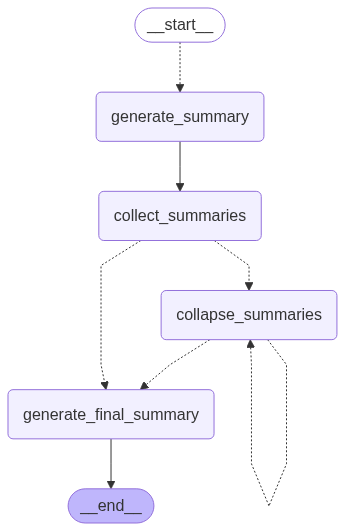

In [54]:
builder = StateGraph(OverallState)

builder.add_node("generate_summary", generate_summary)
builder.add_node("collect_summaries", collect_summaries)
builder.add_node("collapse_summaries", collapse_summaries)
builder.add_node("generate_final_summary", generate_final_summary)

# Edges:
builder.add_conditional_edges(START, map_summaries, ["generate_summary"])
builder.add_edge("generate_summary", "collect_summaries")
builder.add_conditional_edges("collect_summaries", should_collapse)
builder.add_conditional_edges("collapse_summaries", should_collapse)
builder.add_edge("generate_final_summary", END)

graph = builder.compile()

from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [55]:
async for step in graph.astream(
    {'contents': [doc.page_content for doc in split_docs]},
    {'recursion_limit': 10}
):
    print(step)

{'generate_summary': {'summaries': ['This document lists a set of commands and resources for an AI system to perform various tasks, such as searching Google, browsing websites, managing GPT-powered agents, handling files (read, write, delete, search), analyzing and improving code, generating images, sending tweets, and executing Python files. The system has access to the internet, long-term memory, and can delegate tasks to GPT-3.5 agents. Performance is evaluated through continuous self-review, constructive self-criticism, and reflection on past actions, with an emphasis on efficiency and minimizing the number of steps to complete tasks.']}}
{'generate_summary': {'summaries': ['This article provides an overview of LLM-powered autonomous agents, where large language models (LLMs) serve as the core "brain" of the agent. The system is structured around three main components:\n\n1. Planning: The agent decomposes complex tasks into smaller subgoals and uses self-reflection to learn from pa